# Drowsiness Detection System using YOLOv5

---

## Introduction  
This project develops a real-time drowsiness detection system using YOLOv5, aimed at preventing accidents caused by driver fatigue. By analyzing eye closure and head movement patterns, the system detects early signs of drowsiness and triggers visual and auditory alerts.  

The approach follows a structured pipeline :  
1. Dataset Collection & Annotation – Capturing and labeling 'awake' and 'drowsy' images.

2. Model Training (YOLOv5) – Using a custom dataset with optimized hyperparameters.  

3. Real-Time Inference & Alerts – Running the trained model on live webcam footage and activating warnings when drowsiness is detected over a certain consistent duration.  

This ensures fast, accurate and reliable detection, making it suitable for driver safety monitoring systems.

---
---


### To avoid errors and mitigate through exceptions correctly :

Pay Attention to the instructions given in the markdowns below while executing each cell.

In [2]:
# Installing required dependencies
# This cell is installing all necessary libraries at once to ensure the environment is properly set up.

import sys
import subprocess

# List of required packages
required_packages = [
    "torch", "torchvision", "torchaudio",       # PyTorch for YOLOv5
    "opencv-python",                            # OpenCV for real-time video processing
    "matplotlib", "seaborn",                    # Visualization libraries
    "numpy", "pandas",                          # Data handling and numerical operations
    "tqdm",                                     # Progress bar for loops
    "PyYAML",                                   # Handling YAML configurations for training
    "requests",                                 # Fetching images from URLs
    "Pillow",                                   # Image processing
    "scipy", "scikit-learn",                    # Used for potential ML post-processing
    "ultralytics",                              # YOLOv5 framework
    "pygame"                                    # Sound playing
]

# Installing missing packages in a single command
print("Checking and installing missing dependencies.")
subprocess.run([sys.executable, "-m", "pip", "install", "--quiet"] + required_packages)

print("All required dependencies are installed.")

Checking and installing missing dependencies.
All required dependencies are installed.


In [3]:
# Importing All Required Libraries
# This cell is importing all necessary modules used throughout the project.

import os               # File and directory management
import sys              # System-related utilities
import platform         # Detecting the device configuration
import cv2              # OpenCV for real-time video processing
import torch            # PyTorch for deep learning and YOLOv5
import numpy as np      # Numerical operations
import pandas as pd     # Data handling
import requests         # Fetching images from the internet
import time             # Counting down and delay
import json             # Handling annotation files
import shutil           # File operations (copy, move)
import glob             # File search operations
import random           # Randomizing data for training/validation split
import pygame           # Alert sound playing

# Visualization Libraries
import matplotlib.pyplot as plt     # Displaying images
import seaborn as sns               # Statistical visualizations

# Image Processing Libraries
from PIL import Image               # Loading and processing images
from io import BytesIO              # Handling byte-stream data

# Model-related Utilities
from sklearn.model_selection import train_test_split  # Data splitting for experiments

# Displaying successful imports
print("All necessary libraries imported successfully.")

pygame 2.6.1 (SDL 2.28.4, Python 3.13.2)
Hello from the pygame community. https://www.pygame.org/contribute.html
All necessary libraries imported successfully.


In [7]:
# Defining necessary Project Directories and Path Variables

# Defining project root directory
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Defining necessary paths
DATASET_DIR = os.path.join(PROJECT_ROOT, "dataset")
YOLO_DIR = os.path.join(PROJECT_ROOT, "yolov5")
NOTEBOOK_DIR = os.path.join(PROJECT_ROOT, "notebook")
IMAGE_DIR = os.path.join(DATASET_DIR, "images")

# Defining dataset structure
DATASET_STRUCTURE = {
    "images": os.path.join(DATASET_DIR, "images"),
    "train_awake": os.path.join(DATASET_DIR, "train/awake"),
    "train_drowsy": os.path.join(DATASET_DIR, "train/drowsy"),
    "val_awake": os.path.join(DATASET_DIR, "val/awake"),
    "val_drowsy": os.path.join(DATASET_DIR, "val/drowsy"),
}

# Creating directories if they don't exist
for _, folder in DATASET_STRUCTURE.items():
    os.makedirs(folder, exist_ok = True)

print(f"Project directories verified and created if needed at : {PROJECT_ROOT}")

Project directories verified and created if needed at : /Users/bhavikpatwa/Documents/PROJECTS/Drowsiness_Detection_system_using_YOLOv5


In [ ]:
# Cloning YOLOv5 Repository (If Not Already Cloned)
# Ensuring the YOLOv5 model repository is available for training and inference.

# Cloning YOLOv5 into the main project directory
if not os.path.exists(YOLO_DIR):
    print("Cloning YOLOv5 repository :")
    subprocess.run(["git", "clone", "https://github.com/ultralytics/yolov5.git", YOLO_DIR])
    print("YOLOv5 repository cloned successfully.")
else:
    print("YOLOv5 repository already exists. Skipping cloning.")

YOLOv5 repository already exists. Skipping cloning.


In [5]:
# Installing YOLOv5 Dependencies
# Installing YOLOv5-specific requirements from its 'requirements.txt' file.

YOLO_REQUIREMENTS = os.path.join(YOLO_DIR, "requirements.txt")

if os.path.exists(YOLO_REQUIREMENTS):
    print("Installing YOLOv5 dependencies.")
    subprocess.run([sys.executable, "-m", "pip", "install", "-r", YOLO_REQUIREMENTS, "--quiet"])
    print("YOLOv5 dependencies installed.")
else:
    print("YOLOv5 requirements.txt not found.")

Installing YOLOv5 dependencies.
YOLOv5 dependencies installed.


In [6]:
# Verifying library versions & CUDA availability
# Ensuring everything is installed correctly and checks CUDA for GPU acceleration.

print(f"PyTorch Version : {torch.__version__}")
print(f"Torch CUDA Available : {torch.cuda.is_available()}")
print(f"Torch MPS Available : {torch.backends.mps.is_available()}")

# Setting device dynamically
if torch.backends.mps.is_available():
    DEVICE = "mps"      # Metal Performance Shaders (MPS) for Apple devices
elif torch.cuda.is_available():
    DEVICE = "cuda" 
else:
    DEVICE = "cpu"  

print(f"Using device : {DEVICE}")

# Verifying OpenCV Installation
print(f"OpenCV Version : {cv2.__version__}")

PyTorch Version : 2.6.0
Torch CUDA Available : False
Torch MPS Available : True
Using device : mps
OpenCV Version : 4.11.0


In [7]:
# Loading YOLOv5 Pre-trained Model
# This cell is loading the YOLOv5 small version (yolov5s) from TorchHub for object detection.

try:
    model = torch.hub.load("ultralytics/yolov5", "yolov5s", force_reload = False, trust_repo = True)
    model.to(DEVICE)        # Moving model to the selected device (CPU, GPU or MPS)
    print("YOLOv5 model loaded successfully.")
except Exception as e:
    print(f"Error loading YOLOv5 model: {e}")

Using cache found in /Users/bhavikpatwa/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-2-21 Python-3.13.2 torch-2.6.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


YOLOv5 model loaded successfully.


In [8]:
# Loading image for YOLOv5 Detection
# This is loading a sample image from a URL for object detection.

# Defining image source
image_path = "https://upload.wikimedia.org/wikipedia/commons/d/dc/Steve_Jobs_Headshot_2010-CROP_%28cropped_2%29.jpg"

# Trying to load the image
try:
    # Host-Agent setup necessary for accessing the image through proper authorisation
    response = requests.get(image_path, headers = {"User-Agent" : "Mozilla/5.0"}, stream = True)
    response.raise_for_status()         # Checking for request errors
    image = Image.open(BytesIO(response.content))
    print("Image loaded successfully.")
except requests.exceptions.RequestException as e:
    print(f"Error loading image from URL : {e}")
    image = None

Image loaded successfully.


In [9]:
# Running YOLOv5 Model on Image
# This cell is running the loaded image through YOLOv5 to detect objects.

import warnings
warnings.filterwarnings("ignore", category = FutureWarning)  # Suppressing unnecessary warnings

if image:
    results = model(image)                      # Running YOLOv5 inference
    print("YOLOv5 detection completed.")
    
    results.print()                             # Printing detected object details
else:
    print("Skipping detection as image could not be loaded.")

YOLOv5 detection completed.


image 1/1: 2929x3026 1 person, 1 cell phone
Speed: 124.0ms pre-process, 479.6ms inference, 73.3ms NMS per image at shape (1, 3, 640, 640)


<Figure size 640x480 with 0 Axes>

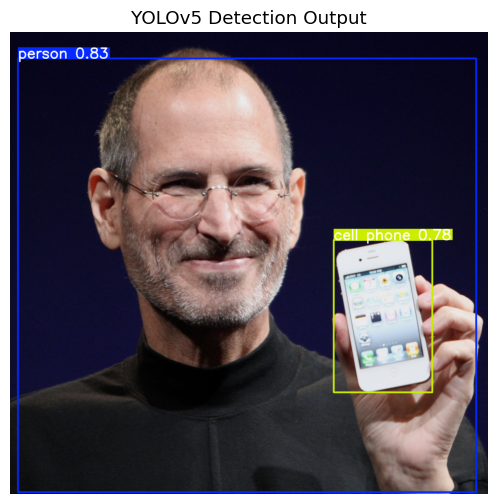

In [10]:
# Displaying YOLOv5 detection output for Sample Image

# This step is not needed in Jupyter Notebook, may be commented
# Ensuring correct inline plotting in VSCode
%matplotlib inline  
plt.close("all")        # Preventing duplicate images from being displayed
plt.clf()               # Clear any cached plots

if image:
    results.render()    # Drawing detections on the image

    # Converting rendered image to NumPy format for Matplotlib
    rendered_image = np.array(results.ims[0])  
    rendered_image = cv2.cvtColor(rendered_image, cv2.COLOR_RGB2BGR)    # Converting to OpenCV BGR format

    # Displaying the image with detections
    plt.figure(figsize = (10, 6))
    plt.imshow(cv2.cvtColor(rendered_image, cv2.COLOR_BGR2RGB))         # Converting BGR to RGB for correct display
    plt.axis("off")     # Hiding axes
    plt.title("YOLOv5 Detection Output")
    plt.show()

# ATTENTION

The following code should connect to the MacBook's primary camera in the first instance and Yolo should detect objects from the video frame.

If, the system connects with the iPhone's camera (Continuity Camera) instead, then :
1. "disconnect" the iPhone camera
2. "restart" the kernel 
3. then try running the code again from the beginning. 

# Press 'q' to exit the camera video frame.

In [11]:
# Real-Time YOLOv5 Object Detection Using MacBook's Default Camera
# Activating the live detection mode using YOLOv5 and the built-in Camera.

# Opening the default device camera
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Failed to access the MacBook's built-in camera.")
else:
    print("Live YOLOv5 detection activated. Press 'q' to exit.")

    while True:
        ret, frame = cap.read()

        if not ret or frame is None:
            print("Warning : Failed to read frame from camera. Retrying.")
            continue

        try:
            # Performing YOLOv5 detection
            results = model(frame)

            # Rendering detection results
            rendered_frame = np.squeeze(results.render())

            # Showing the output frame
            cv2.imshow("YOLOv5 Detection", rendered_frame)

        except Exception as e:
            print(f"Error during YOLOv5 inference : {e}")

        # Exiting loop when 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            print("Exiting YOLOv5 live detection.")
            break

# Releasing camera and closing all OpenCV windows
cap.release()
cv2.destroyAllWindows()
print("Camera released and windows closed.")

Live YOLOv5 detection activated. Press 'q' to exit.


2025-02-27 18:06:20.657 Python[20038:372121] +[IMKClient subclass]: chose IMKClient_Modern
2025-02-27 18:06:20.657 Python[20038:372121] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Exiting YOLOv5 live detection.
Camera released and windows closed.


In [12]:
# Dataset Folder Structure Setup
# Ensuring the necessary dataset directories are created inside the project root.


# Creating necessary directories if they do not exist
for folder_name, folder_path in DATASET_STRUCTURE.items():
    os.makedirs(folder_path, exist_ok = True)

print(f"Dataset folders successfully created at : {DATASET_DIR}")

Dataset folders successfully created at : /Users/bhavikpatwa/Documents/PROJECTS/Drowsiness_Detection_system_using_YOLOv5/dataset


---
The code below is to be used for Image Collection of "awake" and "drowsy" images for training.

The code has been end-to-end commented momentorily to avoid re-running the code each time. Uncomment when needed.

- Use " Cmd " + " / " keypress to comment/uncomment entire code cell together.

---

In [ ]:
# # Image Collection for Training Dataset
# # Collecting images for "awake" and "drowsy" expressions using the webcam.

# # Ensuring the images directory exists
# os.makedirs(IMAGE_DIR, exist_ok = True)

# # Function determining the next available image index
# def get_next_index(label):
#     # Returning the next available index for naming new images sequentially.
#     existing_files = glob.glob(os.path.join(IMAGE_DIR, f"{label}_*.jpg"))
#     existing_indices = [
#         int(os.path.basename(f).split("_")[1].split(".")[0]) 
#         for f in existing_files if "_" in os.path.basename(f)
#     ]
#     return max(existing_indices) + 1 if existing_indices else 0  # Starting from 0 if no existing images

# # Initializing webcam
# cap = cv2.VideoCapture(0)

# if not cap.isOpened():
#     print("Error : Could not access the webcam.")
#     exit()

# # Warm-Up Delay
# print("Warming up the webcam. Please wait for 3 seconds.")
# time.sleep(3)  # Allowing the camera to adjust exposure settings

# # Image Collection metrics
# AWAKE_COUNT = 15   # Number of "awake" images
# DROWSY_COUNT = 15  # Number of "drowsy" images
# INTERVAL = 2       # Capturing interval (seconds)

# # Getting the correct starting indices
# awake_index = get_next_index("awake")
# drowsy_index = get_next_index("drowsy")

# print(f"Starting Image Collection : {AWAKE_COUNT} awake + {DROWSY_COUNT} drowsy images.")
# print(f"Capturing an image every {INTERVAL} seconds.")

# # Collecting Awake Images
# print("\nLOOK AWAKE NOW - Capturing Awake Images :")
# awake_images = 0
# drowsy_images = 0

# while awake_images < AWAKE_COUNT or drowsy_images < DROWSY_COUNT:
#     ret, frame = cap.read()
#     if not ret:
#         print("Warning : Failed to capture frame from webcam.")
#         continue

#     # Determining label and index
#     if awake_images < AWAKE_COUNT:
#         label, index = "awake", awake_index + awake_images
#         awake_images += 1
#         if awake_images == AWAKE_COUNT:  # After capturing all awake images
#             print("\n LOOK DROWSY NOW - Capturing Drowsy Images :")
#             time.sleep(3)  # Small break before switching expressions
#     else:
#         label, index = "drowsy", drowsy_index + drowsy_images
#         drowsy_images += 1

#     # Saving image to dataset
#     image_path = os.path.join(IMAGE_DIR, f"{label}_{index}.jpg")
#     cv2.imwrite(image_path, frame)
#     print(f"Captured {label.capitalize()} Image {index} : {image_path}")

#     time.sleep(INTERVAL)  # Waiting before capturing next image

# print("\nImage collection completed. Proceed with annotation in LabelMe.")

# # Releasing camera resources
# cap.release()
# cv2.destroyAllWindows()
# print("Webcam feed closed.") 

In [ ]:
# Setting up LabelMe Virtual Environment
# Ensuring LabelMe is installed inside a Python 3.11 virtual environment with correct backend configuration.


# Defining virtual environment name
VENV_LABELME = "venv-labelme"

# Creating the virtual environment (if not exists)
if not os.path.exists(VENV_LABELME):
    print("Creating Python 3.11 Virtual Environment for LabelMe.")
    os.system(f"python3.11 -m venv {VENV_LABELME}")
    print("Python 3.11 Virtual Environment Created.")
else:
    print("Virtual Environment already exists.")

# Installing LabelMe & required dependencies in the Virtual Environment
print("Installing/updating required LabelMe dependencies :")
os.system(f"{VENV_LABELME}/bin/python -m pip install --upgrade pip")
os.system(f"{VENV_LABELME}/bin/python -m pip install labelme matplotlib imgviz -q")

print("LabelMe and dependencies installed successfully.")

# Setting suitable Matplotlib Backend
os.environ["MPLBACKEND"] = "TkAgg"  


Virtual Environment already exists.
Installing/updating required LabelMe dependencies :
LabelMe and dependencies installed successfully.


In [ ]:
# Launching LabelMe for annotating collected images
# 1. Click on "Open Directory" and select the "\dataset\images" folder
# 2. For each image, click on "Create Polygon" and draw the correct bounding box on the image. 
#    Draw a box around the face of to indicate awake or drowsy faces for the model to learn.
# 3. Add the correct title for the bounding box drawn - "awake" or "drowsy".
# 4. Save the changes and move to the Next Image.
# 5. Repeat until all images are covered. Close LabelMe when done.

print("Launching LabelMe for annotation.")

# Detecting OS type
is_windows = platform.system() == "Windows"

# Launching LabelMe with the correct command for the OS
if is_windows:
    command = f"{VENV_LABELME}\\Scripts\\activate && labelme \"{IMAGE_DIR}\""
else:
    command = f"source {VENV_LABELME}/bin/activate && labelme \"{IMAGE_DIR}\""

os.system(command)

print("\nAnnotation process completed. Close LabelMe when finished.")

Launching LabelMe for annotation.


2025-02-27 18:06:44.693 | INFO     | labelme.config:get_config:66 - Loading config file from: /Users/bhavikpatwa/.labelmerc
2025-02-27 18:06:45.055 Python[20065:372818] +[IMKClient subclass]: chose IMKClient_Modern
2025-02-27 18:06:45.055 Python[20065:372818] +[IMKInputSession subclass]: chose IMKInputSession_Modern



Annotation process completed. Close LabelMe when finished.


In [ ]:
# Converting LabelMe JSON Annotations to YOLO Format
# Ensuring annotations are correctly formatted for YOLO training. Storing new files in the same directory with json files.


ANNOTATION_DIR = os.path.join(PROJECT_ROOT, "dataset/images")

# Finding JSON annotation files
json_files = glob.glob(os.path.join(ANNOTATION_DIR, "*.json"))

if not json_files:
    print("No JSON annotation files found! Ensure annotations are completed before running this script.")
    exit()

# Defining class labels mapping
CLASS_LABELS = {"drowsy" : 0, "awake" : 1}                        # Mapping labels to YOLO format

for json_file in json_files:
    with open(json_file, "r") as f:
        try:
            data = json.load(f)
        except json.JSONDecodeError:
            print(f"Error : Invalid JSON format in {json_file}. Skipping.")
            continue

    # Validating required keys in JSON
    if "shapes" not in data or "imageWidth" not in data or "imageHeight" not in data:
        print(f"Warning : Missing essential data in {json_file}. Skipping.")
        continue

    # Extracting image dimensions
    img_w, img_h = data["imageWidth"], data["imageHeight"]

    # Extracting image name and defining YOLO output path
    img_name = os.path.basename(json_file).replace(".json", "")
    output_file = json_file.replace(".json", ".txt")

    with open(output_file, "w") as yolo_file:
        for shape in data["shapes"]:
            label = CLASS_LABELS.get(shape["label"].lower())    # Using dictionary lookup
            if label is None:
                print(f"Warning : Unknown label '{shape['label']}' in {json_file}. Skipping this annotation.")
                continue
            # Extracting all points
            x_coords = [point[0] for point in shape["points"]]
            y_coords = [point[1] for point in shape["points"]]

            # Computing bounding box from all four points
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)
            
            # Converting to YOLO format (normalized)
            x_center = ((x_min + x_max) / 2) / img_w
            y_center = ((y_min + y_max) / 2) / img_h
            width = (x_max - x_min) / img_w
            height = (y_max - y_min) / img_h

            # Ensuring height and width are valid
            if width <= 0 or height <= 0:
                print(f"Warning : Invalid bounding box detected in {json_file}. Skipping annotation.")
                continue

            # Writing YOLO format annotation
            yolo_file.write(f"{label} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    print(f"Converted : {json_file} -> {output_file}")

print("\nYOLO conversion is completed. Check your dataset folders.")

Converted : /Users/bhavikpatwa/Documents/PROJECTS/Drowsiness_Detection_system_using_YOLOv5/dataset/images/awake_33.json -> /Users/bhavikpatwa/Documents/PROJECTS/Drowsiness_Detection_system_using_YOLOv5/dataset/images/awake_33.txt
Converted : /Users/bhavikpatwa/Documents/PROJECTS/Drowsiness_Detection_system_using_YOLOv5/dataset/images/drowsy_34.json -> /Users/bhavikpatwa/Documents/PROJECTS/Drowsiness_Detection_system_using_YOLOv5/dataset/images/drowsy_34.txt
Converted : /Users/bhavikpatwa/Documents/PROJECTS/Drowsiness_Detection_system_using_YOLOv5/dataset/images/drowsy_22.json -> /Users/bhavikpatwa/Documents/PROJECTS/Drowsiness_Detection_system_using_YOLOv5/dataset/images/drowsy_22.txt
Converted : /Users/bhavikpatwa/Documents/PROJECTS/Drowsiness_Detection_system_using_YOLOv5/dataset/images/awake_25.json -> /Users/bhavikpatwa/Documents/PROJECTS/Drowsiness_Detection_system_using_YOLOv5/dataset/images/awake_25.txt
Converted : /Users/bhavikpatwa/Documents/PROJECTS/Drowsiness_Detection_syste

In [15]:
# Enforcing train/validation split for collected images 
# Clearing previous files and ensuring an 80-20 dataset split.


# Removing all files inside given directory.
def clear_directory(directory):
    if os.path.exists(directory):
        for f in glob.glob(os.path.join(directory, "*")):
            os.remove(f)        # Removing each file
        print(f"Cleared previous files in {directory}")

# Clearing all train/val folders before new splitting
for folder in [DATASET_STRUCTURE["train_awake"], DATASET_STRUCTURE["train_drowsy"], 
               DATASET_STRUCTURE["val_awake"], DATASET_STRUCTURE["val_drowsy"]]:
    clear_directory(folder)

# Retrieving awake & drowsy images
awake_images = sorted(glob.glob(os.path.join(DATASET_STRUCTURE["images"], "awake_*.jpg")))
drowsy_images = sorted(glob.glob(os.path.join(DATASET_STRUCTURE["images"], "drowsy_*.jpg")))

# Ensuring dataset is not empty
if not awake_images or not drowsy_images:
    print("Error : No images found in the dataset. Ensure images are collected before splitting.")
    exit()

# Shuffling images for randomness
random.seed(42)                 # Ensuring reproducibility
random.shuffle(awake_images)
random.shuffle(drowsy_images)

# Defining exact 80-20 train-val split for awake and drowsy images
split_awake = int(len(awake_images) * 0.8)
split_drowsy = int(len(drowsy_images) * 0.8)

train_awake_images = awake_images[:split_awake]
val_awake_images = awake_images[split_awake:]

train_drowsy_images = drowsy_images[:split_drowsy]
val_drowsy_images = drowsy_images[split_drowsy:]

# Function to copy images & associated annotation files. Moving them to target train/val folders
def copy_files(image_list, target_folder):
    # Copying images and corresponding annotation files to target folder.
    count = 0
    for img in image_list:
        base_name = os.path.basename(img).replace(".jpg", "")

        try:
            # Copying image
            shutil.copy(img, os.path.join(target_folder, os.path.basename(img)))

            # Copying JSON annotation (if exists)
            json_file = img.replace(".jpg", ".json")
            if os.path.exists(json_file):
                shutil.copy(json_file, os.path.join(target_folder, base_name + ".json"))

            # Copying YOLO annotation (if exists)
            txt_file = img.replace(".jpg", ".txt")
            if os.path.exists(txt_file):
                shutil.copy(txt_file, os.path.join(target_folder, base_name + ".txt"))

            count += 1
        except Exception as e:
            print(f"Warning : Failed to copy {img}. Error : {e}")

    print(f"{count} files copied to {target_folder}.")

# Copying train images
print("\nCopying training files :")
copy_files(train_awake_images, DATASET_STRUCTURE["train_awake"])
copy_files(train_drowsy_images, DATASET_STRUCTURE["train_drowsy"])

# Copying validation images
print("\nCopying validation files :")
copy_files(val_awake_images, DATASET_STRUCTURE["val_awake"])
copy_files(val_drowsy_images, DATASET_STRUCTURE["val_drowsy"])

# Displaying final dataset statistics
print("\nDataset Split Summary :")
print(f"Training Data : Awake = {len(train_awake_images)}, Drowsy = {len(train_drowsy_images)}")
print(f"Validation Data : Awake = {len(val_awake_images)}, Drowsy = {len(val_drowsy_images)}")

print("\nDataset split is successfully enforced. Train & validation sets are now correctly structured.")

Cleared previous files in /Users/bhavikpatwa/Documents/PROJECTS/Drowsiness_Detection_system_using_YOLOv5/dataset/train/awake
Cleared previous files in /Users/bhavikpatwa/Documents/PROJECTS/Drowsiness_Detection_system_using_YOLOv5/dataset/train/drowsy
Cleared previous files in /Users/bhavikpatwa/Documents/PROJECTS/Drowsiness_Detection_system_using_YOLOv5/dataset/val/awake
Cleared previous files in /Users/bhavikpatwa/Documents/PROJECTS/Drowsiness_Detection_system_using_YOLOv5/dataset/val/drowsy

Copying training files :
36 files copied to /Users/bhavikpatwa/Documents/PROJECTS/Drowsiness_Detection_system_using_YOLOv5/dataset/train/awake.
36 files copied to /Users/bhavikpatwa/Documents/PROJECTS/Drowsiness_Detection_system_using_YOLOv5/dataset/train/drowsy.

Copying validation files :
9 files copied to /Users/bhavikpatwa/Documents/PROJECTS/Drowsiness_Detection_system_using_YOLOv5/dataset/val/awake.
9 files copied to /Users/bhavikpatwa/Documents/PROJECTS/Drowsiness_Detection_system_using_YOL

In [ ]:
# Verifying contents of created YOLOv5 files
# Checking the contents of .txt files created after conversion of .json files, before training begins

# Function to retrieve and check annotation files
def check_annotation_files(directory, num_files=15):
    # Searching for YOLO .txt annotation files
    annotation_files = glob.glob(os.path.join(directory, "*.txt"))

    # If no annotation files are found
    if not annotation_files:
        print(f"No annotation files found in {directory}")
        return

    # Selecting a few files for verification
    annotation_files = annotation_files[:num_files]  # Limiting to the first few files

    # Checking contents of each file
    print(f"\nChecking {len(annotation_files)} annotation files in {directory} :\n")
    for file in annotation_files:
        print(f"File : {file}")
        with open(file, "r") as f:
            lines = f.readlines()
            for line in lines:
                print(f"Contents : {line.strip()}")     # Displaying each line
        print("-" * 60)                         # Separator for readability

# Verifying annotations in all dataset folders
check_annotation_files(DATASET_STRUCTURE["train_awake"], num_files = 15)
check_annotation_files(DATASET_STRUCTURE["train_drowsy"], num_files = 15)
check_annotation_files(DATASET_STRUCTURE["val_awake"], num_files = 15)
check_annotation_files(DATASET_STRUCTURE["val_drowsy"], num_files = 15)


Checking 15 annotation files in /Users/bhavikpatwa/Documents/PROJECTS/Drowsiness_Detection_system_using_YOLOv5/dataset/train/awake :

File : /Users/bhavikpatwa/Documents/PROJECTS/Drowsiness_Detection_system_using_YOLOv5/dataset/train/awake/awake_8.txt
Contents : 1 0.537202 0.486772 0.284226 0.708995
------------------------------------------------------------
File : /Users/bhavikpatwa/Documents/PROJECTS/Drowsiness_Detection_system_using_YOLOv5/dataset/train/awake/awake_17.txt
Contents : 1 0.544643 0.510582 0.287202 0.703704
------------------------------------------------------------
File : /Users/bhavikpatwa/Documents/PROJECTS/Drowsiness_Detection_system_using_YOLOv5/dataset/train/awake/awake_9.txt
Contents : 1 0.544643 0.498677 0.293155 0.706349
------------------------------------------------------------
File : /Users/bhavikpatwa/Documents/PROJECTS/Drowsiness_Detection_system_using_YOLOv5/dataset/train/awake/awake_29.txt
Contents : 1 0.529762 0.510582 0.260417 0.634921
------------

In [ ]:
# Creating and defining contents of a dataset YAML file

# Defining YAML content
dataset_yaml_contents = f"""
path : {DATASET_DIR}    # Root dataset directory
train : train           # Training images folder 
val : val               # Validation images folder 

# Number of classes
nc : 2                          # Number of object classes
names : ["drowsy", "awake"]     # Class labels
"""

# Ensuring YOLO directory exists
YOLO_DATASET_YAML = os.path.join(YOLO_DIR, "drowsiness_dataset.yaml")

# Saving the YAML file in the YOLO directory
with open(YOLO_DATASET_YAML, "w") as f:
    f.write(dataset_yaml_contents)

print(f"Dataset YAML file created at : {YOLO_DATASET_YAML}")

Dataset YAML file created at : /Users/bhavikpatwa/Documents/PROJECTS/Drowsiness_Detection_system_using_YOLOv5/yolov5/drowsiness_dataset.yaml


---
The code below is to be used for Model Training using YOLOv5 over customized image dataset.

The code has been end-to-end commented momentorily to avoid re-running the code each time. Uncomment when needed.

- Use " Cmd " + " / " keypress to comment/uncomment entire code cell together.

---

In [ ]:
# # Defining model training parameters
# EPOCHS = 150        # Number of training epochs 
# BATCH_SIZE = 16     # Batch size 
# IMG_SIZE = 640      # Image resolution for YOLOv5

# # Ensuring YOLOv5 directory exists before training
# if not os.path.exists(YOLO_DIR):
#     raise FileNotFoundError(f"Error : YOLOv5 directory '{YOLO_DIR}' not found. Ensure it is correctly set up.")

# # Changing working directory to YOLOv5 for running training command
# os.chdir(YOLO_DIR)

# # Constructing the YOLOv5 training command
# train_command = [
#     sys.executable, "train.py",         # YOLOv5 training script
#     "--img", str(IMG_SIZE),             # Image size
#     "--batch", str(BATCH_SIZE),         # Batch size
#     "--epochs", str(EPOCHS),            # Training epochs
#     "--data", YOLO_DATASET_YAML,        # Path to dataset YAML
#     "--weights", "yolov5s.pt",          # Pretrained weights
#     "--device", DEVICE,                 # Use GPU (CUDA/MPS) if available
#     "--patience", "20",                 # Early stopping after 20 epochs if no improvement seen
# ]

# # Printing command for verification
# print("Running YOLOv5 training command :")
# print(" ".join(train_command))

# # Running training using subprocess to execute command
# print("\nYOLOv5 Model Training with customized image dataset started :\n")
# subprocess.run(train_command)

# # Training completed message
# print("\nYOLOv5 Training Completed! \nCheck the 'yolov5/runs/train/' folder for results.")

# Attention

Pick the suitable "expX" file from the "/yolov5/runs/train" folder which yields the best performance. 

- Manually enter the chosen expX file name in the code below before running the next codes.

# Latest successful training : exp6

In [28]:
# Loading the trained model for final testing

# Finding the latest trained model (best.pt or last.pt)
WEIGHTS_DIR = os.path.join(YOLO_DIR, "runs/train/exp6/weights")     # expX filename
model_files = glob.glob(os.path.join(WEIGHTS_DIR, "*.pt"))          # Fetching all .pt files

if not model_files:
    raise FileNotFoundError(f"Error : No trained model (.pt) files found in {WEIGHTS_DIR}. Train the model first.")

# Prioritizing `best.pt` over `last.pt`
if os.path.exists(os.path.join(WEIGHTS_DIR, "best.pt")):
    LATEST_MODEL_PATH = os.path.join(WEIGHTS_DIR, "best.pt")
elif os.path.exists(os.path.join(WEIGHTS_DIR, "last.pt")):
    LATEST_MODEL_PATH = os.path.join(WEIGHTS_DIR, "last.pt")
else:
    raise FileNotFoundError(f"Error : No best.pt or last.pt found in {WEIGHTS_DIR}.")

print(f"Using trained model : {LATEST_MODEL_PATH}")

# Loading YOLOv5 with the latest trained model
print("Loading trained YOLOv5 model :")
model = torch.hub.load("ultralytics/yolov5", "custom", path = LATEST_MODEL_PATH, force_reload = False)
model.to(DEVICE)            # Moving model to selected device (CPU/GPU)
print("Model loaded successfully.")

Using cache found in /Users/bhavikpatwa/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-2-21 Python-3.13.2 torch-2.6.0 CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


Using trained model : /Users/bhavikpatwa/Documents/PROJECTS/Drowsiness_Detection_system_using_YOLOv5/yolov5/runs/train/exp6/weights/best.pt
Loading trained YOLOv5 model :
Model loaded successfully.


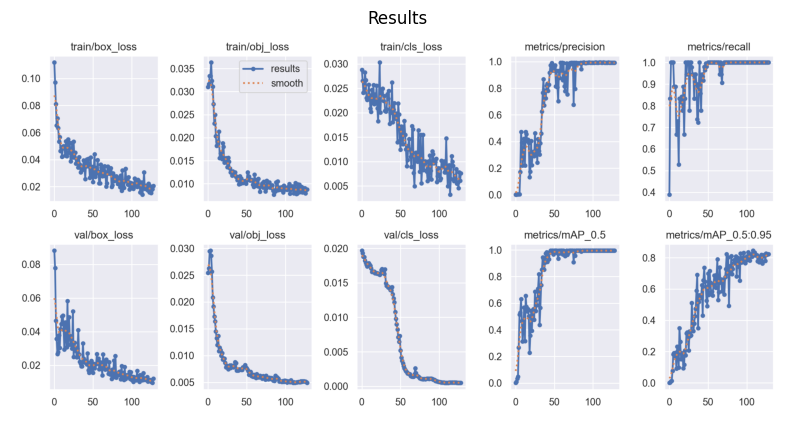

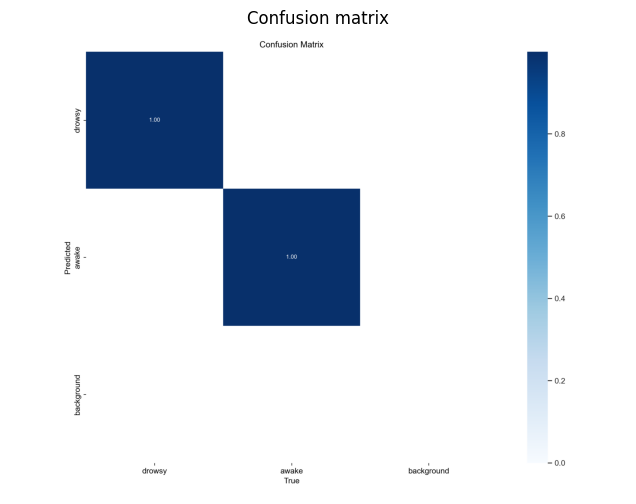

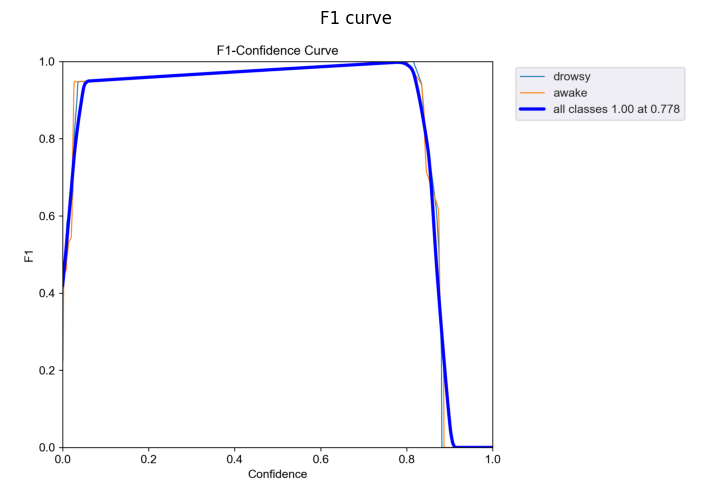

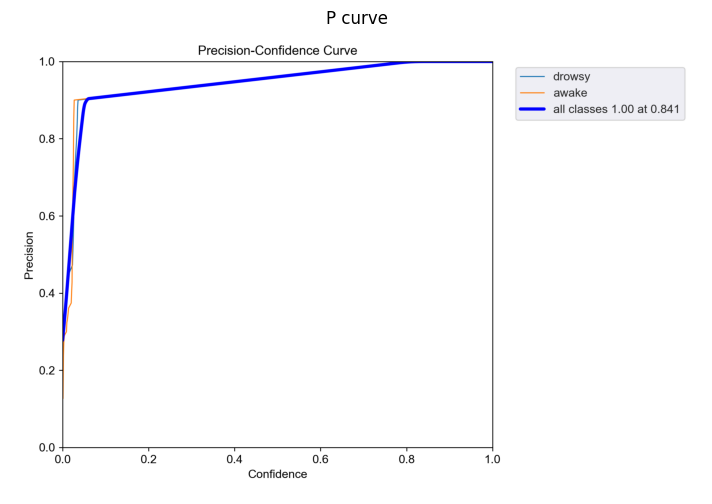

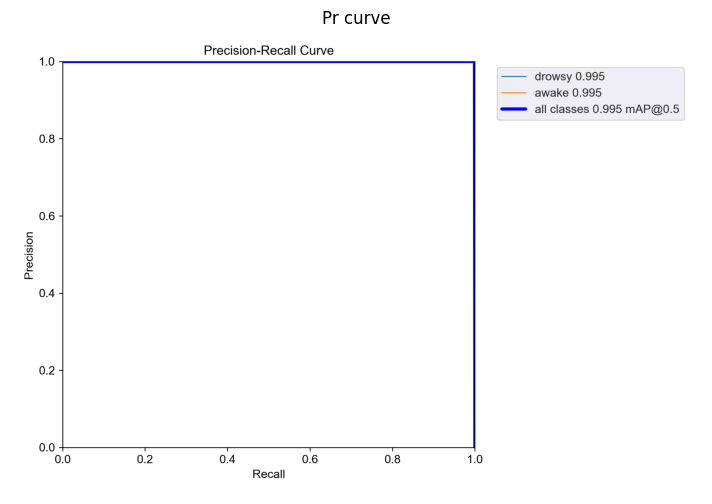

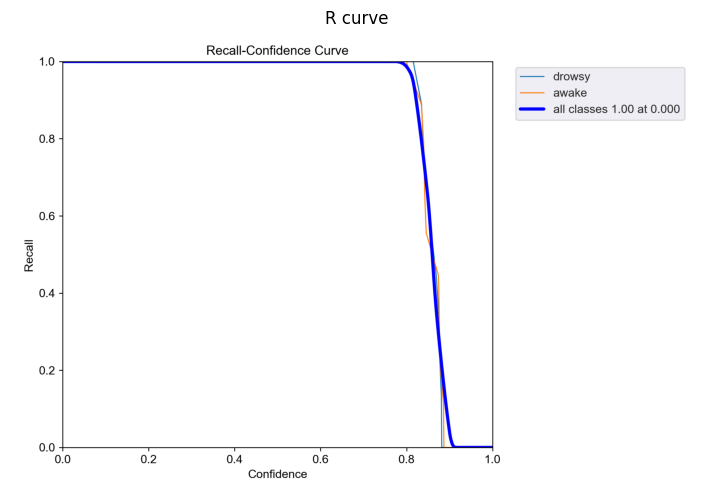

In [8]:
# Define the experiment folder (replace 'expX' with your actual experiment name)
exp_folder = os.path.join(YOLO_DIR, "runs/train/exp6")  # Change to your latest experiment folder

# List of graph filenames
graph_files = ["results.png", "confusion_matrix.png", "F1_curve.png", "P_curve.png", "PR_curve.png", "R_curve.png"]

# Display each graph
for graph in graph_files:
    graph_path = os.path.join(exp_folder, graph)
    
    if os.path.exists(graph_path):
        img = cv2.imread(graph_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper display

        plt.figure(figsize=(10,6))
        plt.imshow(img)
        plt.axis("off")
        plt.title(graph.replace("_", " ").replace(".png", "").capitalize())  # Format title
        plt.show()
    else:
        print(f"⚠️ Warning: {graph} not found in {exp_folder}")

Running inference on : /Users/bhavikpatwa/Documents/PROJECTS/Drowsiness_Detection_system_using_YOLOv5/dataset/images/drowsy_0.jpg


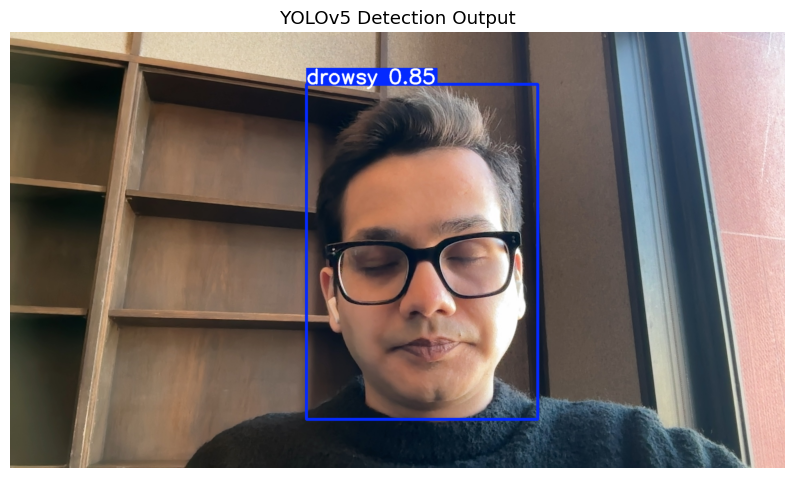

In [19]:
# Sample Image Testing for YOLOv5 Drowsiness detection

# Defining path to a test image (you can replace with any image path)
TEST_IMAGE_PATH = os.path.join(PROJECT_ROOT, "dataset", "images", "drowsy_0.jpg")

# Checking if test image exists
if not os.path.exists(TEST_IMAGE_PATH):
    raise FileNotFoundError(f"Error : Test image '{TEST_IMAGE_PATH}' not found.")

# Running inference on the test image
print(f"Running inference on : {TEST_IMAGE_PATH}")
results = model(TEST_IMAGE_PATH)

# Rendering results
results.render()

# Converting image to OpenCV format for displaying
rendered_image = results.ims[0]
rendered_image = cv2.cvtColor(rendered_image, cv2.COLOR_RGB2BGR)

# Displaying the image
plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(rendered_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("YOLOv5 Detection Output")
plt.show()

In [45]:
# Real-Time YOLOv5 Drowsiness Detection using WebCam Video (Testing) 

# Opening the webcam
cap = cv2.VideoCapture(0)

# Checking if camera is accessible
if not cap.isOpened():
    raise RuntimeError("Error : Could not access webcam.")

print("Live YOLOv5 detection activated. Press 'q' to exit.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Warning : Failed to read frame from webcam.")
        continue

    # Performing YOLOv5 inference
    results = model(frame)

    # Rendering detection results on the frame
    rendered_frame = results.render()[0]

    # Displaying the frame
    cv2.imshow("YOLOv5 Real-Time Detection", rendered_frame)

    # Exiting the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord("q"):
        print("Exiting real-time detection.")
        break

# Releasing webcam and close all windows
cap.release()
cv2.destroyAllWindows()
print("Webcam feed closed.")

Live YOLOv5 detection activated. Press 'q' to exit.
Exiting real-time detection.
Webcam feed closed.


In [ ]:
# Real-Time Video YOLOv5 Drowsiness detection and Sound Alert

# Defining alert sound file
ALERT_SOUND_PATH = os.path.join(PROJECT_ROOT, "alert_sound.wav")

# Initializing pygame mixer for playing alert sounds
pygame.mixer.init()
alert_sound = pygame.mixer.Sound(ALERT_SOUND_PATH)

# Opening the webcam
cap = cv2.VideoCapture(0)

# Checking if camera is accessible
if not cap.isOpened():
    raise RuntimeError("Error : Could not access webcam.")

print("Live YOLOv5 detection activated. Press 'q' to exit.")

# Alerting system variables
drowsy_frame_count = 0      # Count of consecutive drowsy detections
ALERT_THRESHOLD = 20         # Trigger alert after detecting drowsiness for 5 consecutive frames
ALERT_PLAYING = False       # Flag to prevent continuous sound playing

while True:
    ret, frame = cap.read()
    if not ret:
        print("Warning : Failed to read frame from webcam.")
        continue

    # Performing YOLOv5 inference
    results = model(frame)

    # Extracting detected classes
    detected_classes = results.pandas().xyxy[0]['name'].tolist()

    # Checking if "drowsy" is detected
    if "drowsy" in detected_classes:
        drowsy_frame_count += 1     # Increment count
    else:
        drowsy_frame_count = 0      # Reset count if no drowsiness detected

    # Trigger alert if drowsiness is detected for consecutive frames
    if drowsy_frame_count >= ALERT_THRESHOLD:
        if not ALERT_PLAYING:
            print("ALERT : Drowsiness Detected!")
            pygame.mixer.Sound.play(alert_sound)        # Playing alarm sound
            ALERT_PLAYING = True

        # Displaying warning on screen
        cv2.putText(frame, "DROWSINESS DETECTED!", (50, 100),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3, cv2.LINE_AA)
        cv2.putText(frame, "PAY ATTENTION!!!", (50, 200),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3, cv2.LINE_AA)
        

    else:
        ALERT_PLAYING = False       # Resetting flag if drowsiness is no longer detected

    # Rendering detection results on the frame
    rendered_frame = results.render()[0]

    # Displaying the frame
    cv2.imshow("YOLOv5 Real-Time Detection", rendered_frame)

    # Exitting loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord("q"):
        print("Exiting real-time detection.")
        break

# Releasing webcam and close all windows
cap.release()
cv2.destroyAllWindows()
pygame.mixer.quit()         # Stopping audio system
print("Webcam feed closed.")

Live YOLOv5 detection activated. Press 'q' to exit.
ALERT : Drowsiness Detected!
ALERT : Drowsiness Detected!
ALERT : Drowsiness Detected!
ALERT : Drowsiness Detected!
ALERT : Drowsiness Detected!
Exiting real-time detection.
Webcam feed closed.


---
---
## Conclusion 

The trained YOLOv5 model (best.pt from exp6) delivers high precision (99.3%) and recall (100%), ensuring near-zero false negatives while maintaining efficient real-time performance. The system successfully :  
- Detects drowsiness with minimal computational overhead.
- Triggers alerts if drowsiness persists for 20 frames.
- Maintains low loss values, ensuring stable convergence.  

### Model Performance & Evaluation :
- Precision = 99.3%
    - Very few false positives.
- Recall = 100%
    - No drowsiness cases missed.
- mAP@0.5 = 99.5%
    - Highly accurate detection.
- mAP@0.5:0.95 = 84.5%
    - Strong performance across varying IoU thresholds.
- Training Loss Metrics :
  - Box Loss reduced from 0.11 to 0.017 (precise localization).
  - Object Loss decreased from 0.03 to 0.005 (higher confidence).
  - Classification Loss dropped from 0.028 to 0.001 (better class separation).

### Key Insights & Future Enhancements :
Why This Approach Worked Well? : 
- Adaptive YOLOv5 training enhanced detection accuracy.  
- Balanced dataset & fine-tuned anchors reduced false detections.  
- Early stopping (epoch 129) ensured optimal generalization.  

Challenges & Possible Enhancements :
- Low-light detection issues – The model may struggle in dim conditions.  
Solution : Enhancing dataset diversity with night-time images and applying adaptive brightness correction.  

- Head movement variations – Sudden movements or looking away might affect classification.  
Solution : Implementing temporal tracking (tracking eye states over time) to reduce misclassifications.  

- Short detection windows – Immediate alerts may cause false alarms.  
Solution : Using rolling frame analysis (e.g. averaging over 30+ frames) to improve detection consistency.  
